<a href="https://colab.research.google.com/github/kaziandelib/ImageClassBigCats/blob/main/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup and Load Data

In [ ]:
# To import the necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2 as cv
import imghdr

In [ ]:
# To mount google drive
# Optional, use if working with colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# To assign the data directory
data_dir = '/content/drive/MyDrive/ImageClassifier/cats'

# Data obtained from kaggle link below
# https://www.kaggle.com/datasets/crownedhead06/big-cats-images-dataset
# Data dir should be changed accordingly

In [ ]:
# To see the files in the data directory

os.listdir(data_dir)

['mountain_lions',
 'cheetahs',
 'jaguars',
 'leopards',
 'eurasian_lynx',
 'panthers',
 'snow_leopards',
 'lions',
 'tigers']

In [ ]:
# To declare the types of file extensions allowed

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

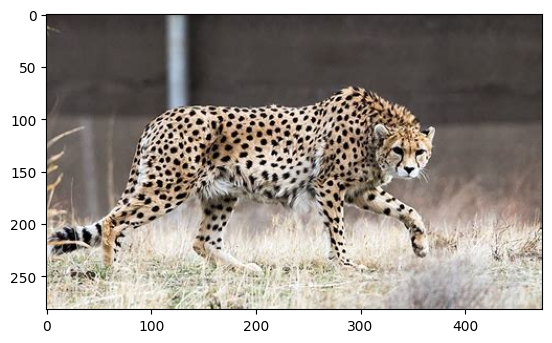

In [ ]:
# To show a random image from the dataset

img = cv.imread(os.path.join('/content/drive/MyDrive/ImageClassifier/cats', '/content/drive/MyDrive/ImageClassifier/cats/cheetahs', 'image44.jpg'))
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.show()

In [ ]:
# To remove dodgy images

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f"Image not in ext list {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')


In [ ]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/ImageClassifier/cats')

Found 865 files belonging to 9 classes.


In [ ]:
# To assign the iterator

data_iterator = data.as_numpy_iterator()

In [ ]:
# To get a batch for the iterator

batch = data_iterator.next()

In [ ]:
# To represent the image as a numpy array

batch[0].shape

(32, 256, 256, 3)

In [ ]:
# To represent the image as a numpy array

batch[1]

array([3, 1, 5, 7, 1, 1, 4, 6, 4, 5, 7, 8, 6, 7, 7, 1, 8, 2, 4, 5, 5, 0,
       6, 4, 4, 0, 3, 0, 6, 0, 4, 3], dtype=int32)

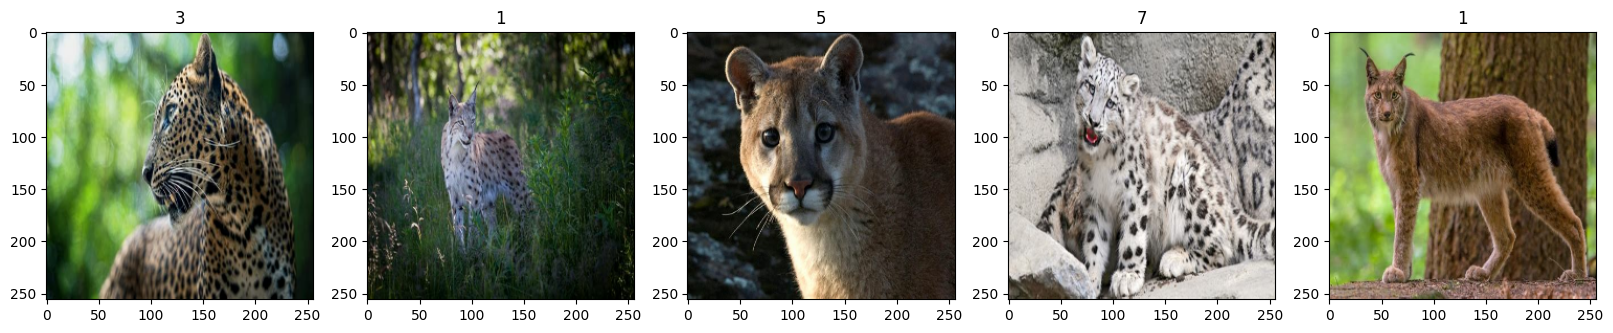

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing Data

In [ ]:
# To scale the data

scaled_data = data.map(lambda a, b : (a/255, b)) # a -> images, b -> labels

In [ ]:
scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()
print(f'Min: {batch[0].min()} and Max: {batch[0].max()}')

Min: 0.0 and Max: 1.0


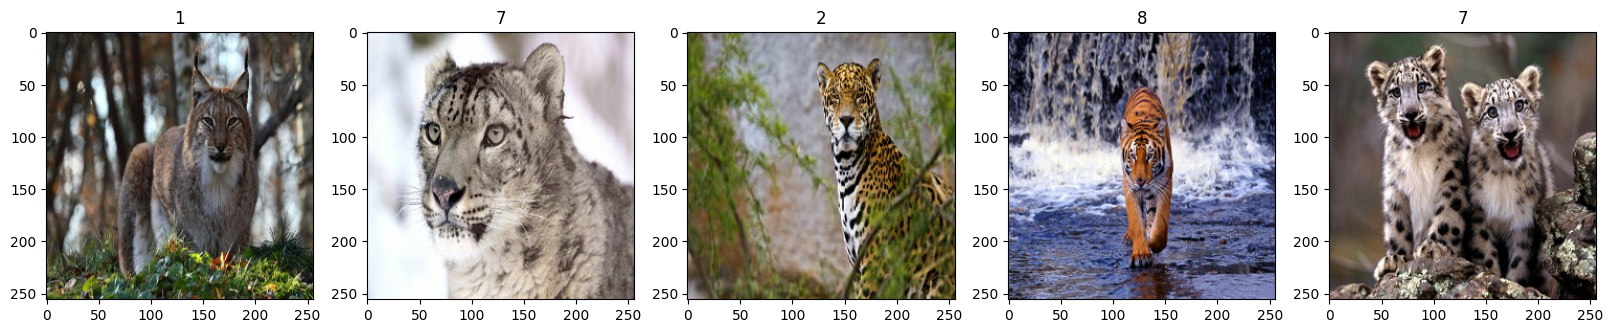

In [ ]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Spitting the data

In [ ]:
len(scaled_data)

28

In [ ]:
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.2) + 1
test_size = int(len(scaled_data) * 0.1) + 1

total = test_size + val_size + train_size

print(f'Train Size: {train_size}, Val Size: {val_size}, Test Size: {test_size}')
print(f'Total Size : {total}')

Train Size: 19, Val Size: 6, Test Size: 3
Total Size : 28


In [ ]:
train  = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size+val_size).take(test_size)

print(f'Training length: {len(train)}, Validation length: {len(val)}, Testing length: {len(test)}')

Training length: 19, Validation length: 6, Testing length: 3


Deep Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

# Flatten layer
model.add(Flatten())

# Dense layer with dropout
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Dropout with 50% rate

# Output layer
model.add(Dense(9, activation='softmax'))  # softmax for multi-class classification


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('adam', loss=tf.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           2,313 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,698,681 (14.11 MB)

 Trainable params: 3,698,681 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

Training the Model

In [ ]:
# To create the logs
!mkdir logs

logdir  = 'logs'
tensorboard_callback  = tf.keras.callbacks.TensorBoard(log_dir=logdir)

mkdir: cannot create directory ‘logs’: File exists


In [ ]:
# To train the model

history =  model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1019 - loss: 2.3670 - val_accuracy: 0.1927 - val_loss: 2.1491
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.2728 - loss: 2.0735 - val_accuracy: 0.3802 - val_loss: 1.7948
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3834 - loss: 1.7809 - val_accuracy: 0.5677 - val_loss: 1.4915
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4843 - loss: 1.4467 - val_accuracy: 0.6094 - val_loss: 1.3060
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6254 - loss: 1.1677 - val_accuracy: 0.6667 - val_loss: 1.1187
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7026 - loss: 0.9334 - val_accuracy: 0.6458 - val_loss: 0.9509
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7112 - loss: 0.7887 - val_accuracy: 0.6406 - val_loss: 0.9683
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.8099 - loss: 0.6378 - val_accuracy: 0.7865 - val_loss:

Plot Performance

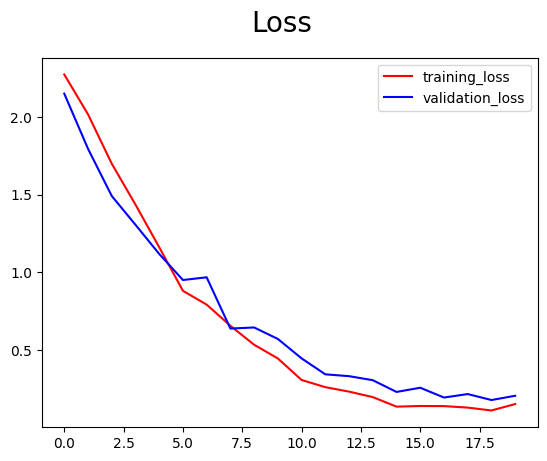

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='training_loss')
plt.plot(history.history['val_loss'], color='blue', label='validation_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

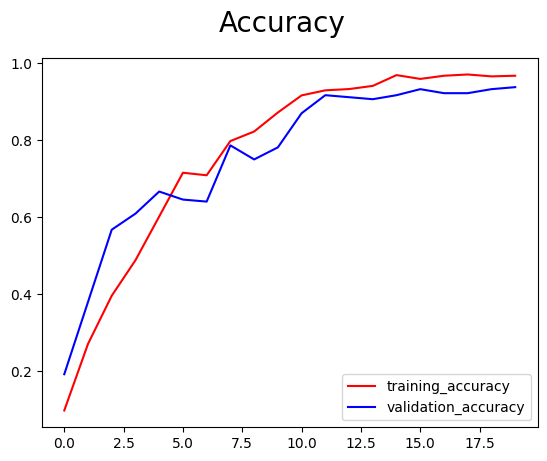

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='red', label='training_accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='validation_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='lower right')
plt.show()

Elavuating the model


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


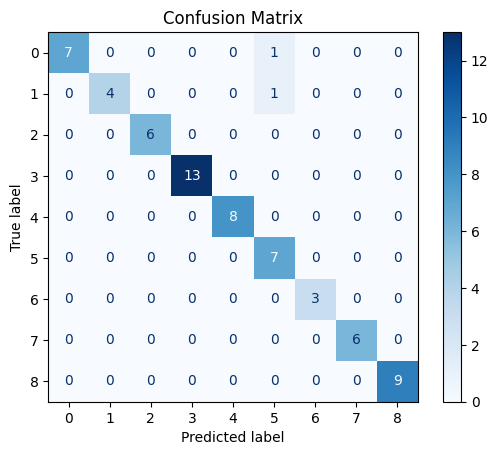

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Precision, Recall

# To define metrics
accuracy = SparseCategoricalAccuracy()
precision = Precision()
recall = Recall()

# To create lists to hold true labels and predicted labels
y_true_list = []
y_pred_list = []
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)

    # Tp update accuracy
    accuracy.update_state(y, y_pred)

    # To onvert predictions to class indices
    y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

    # To update precision and recall for each class (macro-averaging)
    precision.update_state(y, y_pred_classes)

    # To check the shape of y
    if len(y.shape) > 1:  # If y is one-hot encoded
        y_true_list.extend(np.argmax(y, axis=1))
    else:  # If y is a 1D array of class indices
        y_true_list.extend(y)

    y_pred_list.extend(y_pred_classes)

# To convert lists to arrays for confusion matrix
y_true_array = np.array(y_true_list)
y_pred_array = np.array(y_pred_list)

# To generate and display the confusion matrix
cm = confusion_matrix(y_true_array, y_pred_array)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

Testing The Model

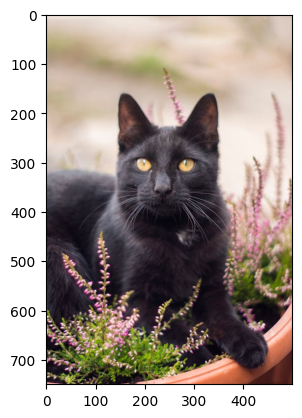

In [ ]:
test_img1 = cv.imread('/content/drive/MyDrive/ImageClassifier/Tests/TestTiger.jpg')
test_img2 = cv.imread('/content/drive/MyDrive/ImageClassifier/Tests/pexels-photo-1424687.jpeg') # Cat just for fun
test_img3 = cv.imread('/content/drive/MyDrive/ImageClassifier/Tests/pexels-photo-1598377.jpeg')
test_img4 = cv.imread('/content/drive/MyDrive/ImageClassifier/Tests/pexels-photo-88234.jpeg')

plt.imshow(cv.cvtColor(test_img2, cv.COLOR_BGR2RGB))
plt.show()

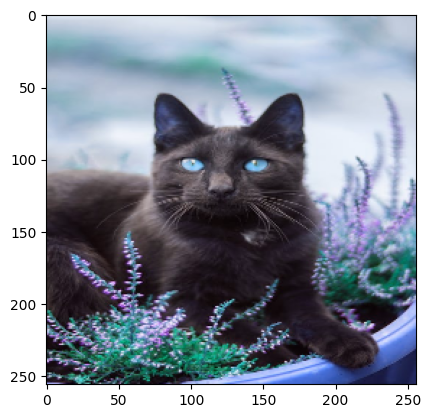

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted class: 6


In [ ]:
resizedImg = tf.image.resize(test_img2, (256,256))
normalizedImg = resizedImg / 255.0
plt.imshow(normalizedImg.numpy())
plt.show()
y_test_pred = model.predict(np.expand_dims(normalizedImg, axis=0))
y_test_pred = np.argmax(y_test_pred)
print(f'Predicted class: {y_test_pred}')

In [ ]:
if y_test_pred == 0:
    print('This is a cheetah')
elif y_test_pred == 1:
    print('This is a eurasian_lynx')
elif y_test_pred == 2:
    print('This is a jaguar')
elif y_test_pred == 3:
    print('This is a leopard')
elif y_test_pred == 4:
    print('This is a lion')
elif y_test_pred == 5:
    print('This is a mountain_lion')
elif y_test_pred == 6:
    print('This is a panther')
elif y_test_pred == 7:
    print('This is a snow leopard')
elif y_test_pred == 8:
    print('This is tiger')
else:
  print

This is a panther
